# Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.nn import functional as F

import math
import os
import random
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Read Data

In [3]:
SPECTROGRAM_DIR = os.path.join("output", "dataSet", "spectrogram")
LABEL_PATH = os.path.join("output", "dataSet", "labels.json")
METADATA_PATH = os.path.join("output", "dataSet", "metadata.json")

In [4]:
class BoundingBoxDataset(Dataset):
    def __init__(self, spectrogramDir, labelsPath, metaDataPath):
        # TODO: Add metadata to the dataset
        # Read labels from file
        self.labelTable: dict = json.load(open(labelsPath))
        self.metaDataTable: dict = json.load(open(metaDataPath))
        # Read all spectrograms from directory
        self.spectrograms = []
        self.metadata = []
        self.labels = []
        
        for fileName in self.labelTable.keys():
            # Read spectrogram image
            img = cv2.imread(os.path.join(spectrogramDir, fileName))
            # Resize the image to 64x64
            img = cv2.resize(img, (64, 64))
            # Convert to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Reshape to (1, 64, 64)
            img = img.reshape(1, 64, 64)
            # Normalize the image
            # 1. Convert to float32
            img = img.astype(np.float32)
            # 2. Subtract min
            img -= np.amin(img)
            # 3. Divide by max
            img /= np.amax(img)
            # Convert to tensor
            img = torch.from_numpy(np.array(img))
            self.spectrograms.append(img)
            
            # Read metadata
            metadata = self.metaDataTable[fileName]
            metadata = np.array(
                [
                    metadata["startFreq"],
                    metadata["endFreq"],
                    metadata["timeSpan"]
                ]
            )
            # Convert to float32
            metadata = metadata.astype(np.float32)
            self.metadata.append(torch.from_numpy(metadata))
            
            # Transform label to np array
            label = np.array(
                [
                    int(
                        self.labelTable[fileName]["isPositive"]
                    ),
                    self.labelTable[fileName]["offset"]["x"],
                    self.labelTable[fileName]["offset"]["y"],
                    self.labelTable[fileName]["offset"]["w"],
                    self.labelTable[fileName]["offset"]["h"]
                ]
            )
            # Convert to float32
            label = label.astype(np.float32)
            self.labels.append(torch.from_numpy(label))
        

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.metadata[idx], self.labels[idx]

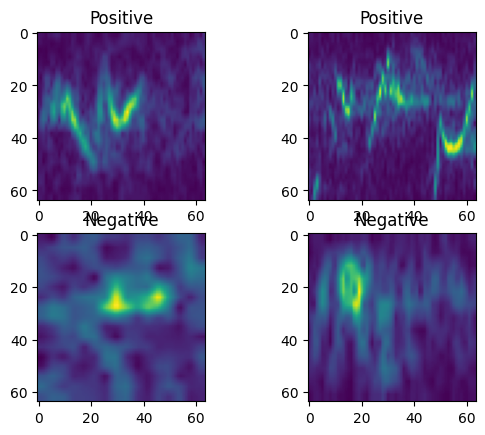

In [5]:
boundingBoxDataset = BoundingBoxDataset(SPECTROGRAM_DIR, LABEL_PATH, METADATA_PATH)
fig, ax = plt.subplots(2, 2)
# Randomly pick 2 positive and 2 negative spectrograms
positiveIdxs = [idx for idx, label in enumerate(boundingBoxDataset.labels) if label[0] == 1]
negativeIdxs = [idx for idx, label in enumerate(boundingBoxDataset.labels) if label[0] == 0]
for i in range(2):
    indx = random.choice(positiveIdxs)
    ax[0][i].imshow(boundingBoxDataset.spectrograms[indx].reshape(64, 64))
    ax[0][i].set_title("Positive")
for i in range(2):
    indx = random.choice(negativeIdxs)
    ax[1][i].imshow(boundingBoxDataset.spectrograms[indx].reshape(64, 64))
    ax[1][i].set_title("Negative")

## Split Train and Test Data

In [6]:
# Split data set.
trainDataSetSize = int(len(boundingBoxDataset) * 0.8)
testDataSetSize = len(boundingBoxDataset) - trainDataSetSize
trainDataSet, testDataSet = random_split(
    boundingBoxDataset,
    [trainDataSetSize, testDataSetSize]
)
# Generate dataloaders
trainLoader = DataLoader(trainDataSet, batch_size=4, shuffle=True)
testLoader = DataLoader(testDataSet, batch_size=4, shuffle=True)

len(trainLoader), len(testLoader)

(829, 208)

# Training

In [7]:
# Defining Model
class BoundingBoxClassifier(nn.Module):
    """
    The BoundingBoxClassifier model takes in a spectrogram image and the bounding box metadata as input.
    The spectrogram image size is 64x64.
    The bounding box metadata is a 3-dimensional tensor with start frequency, end frequency, and time span.
    SPECTROGRAM MUST BE FLATTENED TO 1 DIMENSION and COMBINED WITH THE METADATA.
    """
    def __init__(self):
        super().__init__()
        # Input shape is 1x64x64
        # Convolutional layer (1*64*64 -> 16*62*62)
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # Max pooling layer (16*62*62 -> 16*31*31)
        self.pool1 = nn.MaxPool2d(2, 2)
        # Convolutional layer (16*31*31 -> 32*27*27)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        # Max pooling layer (32*27*27 -> 32*9*9)
        self.pool2 = nn.MaxPool2d(3, 3)
        # Fully connected layer (32*9*9 -> 64)
        self.fc1 = nn.Linear(32 * 9 * 9, 64)
        # Hidden layer (64 -> 32)
        self.fc2 = nn.Linear(64, 32)
        # Hidden layer for metadata (3 -> 3)
        self.fc3 = nn.Linear(3, 3)
        # Output layer (32 + 3 -> 1) for classification
        self.outClassification = nn.Linear(32 + 3, 1)
        # Output layer (32 + 3 -> 4) for offset prediction
        self.outOffset = nn.Linear(32 + 3, 4)
    
    def forward(self, x):
        # Split the x into spectrogram image and bounding box metadata
        # Get the first 1*64*64 tensor
        img = x[:, :1*64*64]
        # Get the last 3 tensor
        metadata = x[:, -3:]
        # Log the metadata to make the values smaller
        metadata += 1
        metadata = torch.log(metadata)
        
        # Reshape the image to (1, 64, 64)
        img = img.reshape(-1, 1, 64, 64)
        
        # Convolutional layer
        x = self.conv1(img)
        x = F.relu(x)
        # Max pooling layer
        x = self.pool1(x)
        # Convolutional layer
        x = self.conv2(x)
        x = F.relu(x)
        # Max pooling layer
        x = self.pool2(x)
        # Flatten layer
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        # Hidden layer
        x = self.fc2(x)
        x = F.relu(x)
        
        # Hidden layer for metadata
        metadata = self.fc3(metadata)
        metadata = F.relu(metadata)
        
        # Concatenate the hidden layer and metadata
        x = torch.cat((x, metadata), 1)
        
        # Output layer
        predictedClass = self.outClassification(x)
        predictedClass = torch.sigmoid(predictedClass)
        predictedOffset = self.outOffset(x)
        return predictedClass, predictedOffset

## Utils

In [8]:
def GetModelOffsetLoss(model, loader, lossFunc):
    """
    Get the accuracy of the model on the given loader.
    """
    totalLoss = 0
    with torch.no_grad():
        for data in loader:
            images, metadata, labels = data
            images = images.to(device)
            metadata = metadata.to(device)
            labels = labels.to(device)
            
            # Resize the image to 1 dimension
            images = images.reshape(images.size(0), -1)
            # Resize the metadata to 1 dimension
            metadata = metadata.reshape(images.size(0), -1)
            imputs = torch.cat((images, metadata), dim=1)
            
            predictedClass, predictedOffset = model(imputs)
            # Calculate the loss
            loss = lossFunc(predictedOffset, labels[:, -4:])
            
            totalLoss += loss.item()
    
    return totalLoss / len(loader)

def GetModelClassificationAccuracy(model, loader):
    """
    Get the accuracy of the model on the given loader.
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, metadata, labels = data
            images = images.to(device)
            metadata = metadata.to(device)
            labels = labels.to(device)
            
            # Resize the image to 1 dimension
            images = images.reshape(images.size(0), -1)
            # Resize the metadata to 1 dimension
            metadata = metadata.reshape(images.size(0), -1)
            inputs = torch.cat((images, metadata), dim=1)
            
            predictedClass, predictedOffset = model(inputs)
            # Round the predicted class to 0 or 1
            predicted = torch.round(predictedClass)
            # Calculate the accuracy
            correct += (predicted == labels[:, 0].reshape(labels.size(0), -1)).sum().item()
            total += labels.size(0)
    
    return correct / total

In [9]:
# Init params
EPOCHS = 100
LEARNING_RATE = 0.001

In [10]:
# Init model
model = BoundingBoxClassifier()
# Move model to GPU if available
model.to(device)

# Defining loss function and optimizer
classificationLoss = nn.BCELoss()
offsetLoss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
history = pd.DataFrame(columns=[
    "epoch", "train_acc", "test_acc", "train_offset_loss", "test_offset_loss"
])

# Get the accuracy of the model on the test set
startTrainAcc = GetModelClassificationAccuracy(model, trainLoader)
startTestAcc = GetModelClassificationAccuracy(model, testLoader)
print("Start train accuracy:", startTrainAcc)
print("Start test accuracy:", startTestAcc)

# Get the loss of the model on the train and test data sets
startTrainLoss = GetModelOffsetLoss(model, trainLoader, offsetLoss)
startTestLoss = GetModelOffsetLoss(model, testLoader, offsetLoss)
print("Training set offset loss: {}".format(startTrainLoss))
print("Test set offsetloss: {}".format(startTestLoss))
history.loc[0] = [0, startTrainAcc, startTestAcc, startTrainLoss, startTestLoss]

stepNum = len(trainLoader)
# Training
for epoch in range(EPOCHS):
    print("=====Epoch {}/{}=====".format(epoch + 1, EPOCHS))
    for i, (spectrogram, metadata, label) in enumerate(trainLoader):
        # Convert spectrogram and label to tensors
        spectrogram = spectrogram.to(device)
        metadata = metadata.to(device)
        label = label.to(device)
        
        # Resize the image to 1 dimension
        spectrogram = spectrogram.reshape(spectrogram.size(0), -1)
        metadata = metadata.reshape(spectrogram.size(0), -1)
        # Combine spectrogram and metadata into a single tensor
        inputs = torch.cat((spectrogram, metadata), dim=1)
        # Forward pass
        predictedClass, predictedOffset = model(inputs)
        
        # Compute loss for classification
        loss = (
            classificationLoss(predictedClass, label[:, 0].reshape(label.size(0), -1))
            + offsetLoss(predictedOffset, label[:, -4:])
        )
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % (stepNum // 4) == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")
    # Get the accuracy of the model on the train and test data sets
    trainAcc = GetModelClassificationAccuracy(model, trainLoader)
    testAcc = GetModelClassificationAccuracy(model, testLoader)
    print("Training set accuracy: {}".format(trainAcc))
    print("Test set accuracy: {}".format(testAcc))
    # Get the loss of the model on the train and test data sets
    trainLoss = GetModelOffsetLoss(model, trainLoader, offsetLoss)
    testLoss = GetModelOffsetLoss(model, testLoader, offsetLoss)
    print("Training set loss: {}".format(trainLoss))
    print("Test set loss: {}".format(testLoss))
    # Save accuracy to history
    history.loc[len(history)] = [epoch + 1, trainAcc, testAcc, trainLoss, testLoss]

Start train accuracy: 0.73854041013269
Start test accuracy: 0.7301204819277108
Training set offset loss: 538.798338586523
Test set offsetloss: 748.6417549370985
=====Epoch 1/100=====
Epoch 1, Batch 207, Loss: 1.2011
Epoch 1, Batch 414, Loss: 7.0088
Epoch 1, Batch 621, Loss: 6.5745
Epoch 1, Batch 828, Loss: 39.1073
Training set accuracy: 0.7599517490952955
Test set accuracy: 0.7662650602409639
Training set loss: 516.5516387679321
Test set loss: 741.2581898478361
=====Epoch 2/100=====
Epoch 2, Batch 207, Loss: 10.6070
Epoch 2, Batch 414, Loss: 12.9395
Epoch 2, Batch 621, Loss: 3.0046
Epoch 2, Batch 828, Loss: 128.4935
Training set accuracy: 0.7490952955367913
Test set accuracy: 0.7385542168674699
Training set loss: 510.6680410976721
Test set loss: 738.1839672728227
=====Epoch 3/100=====
Epoch 3, Batch 207, Loss: 16.7442
Epoch 3, Batch 414, Loss: 13.5961
Epoch 3, Batch 621, Loss: 26.0236
Epoch 3, Batch 828, Loss: 117.7370
Training set accuracy: 0.7895054282267793
Test set accuracy: 0.7939

# Validation

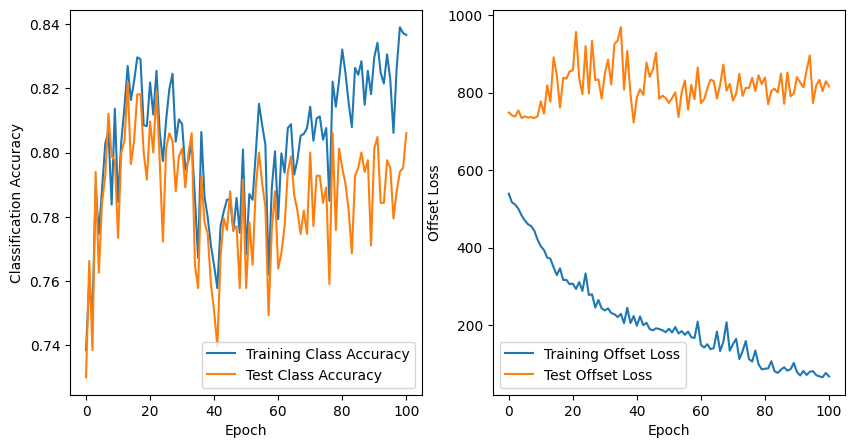

In [12]:
# Plot accuracy over epochs
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
ax[0].plot(history["epoch"], history["train_acc"], label="Training Class Accuracy")
ax[0].plot(history["epoch"], history["test_acc"], label="Test Class Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Classification Accuracy")
ax[0].legend()
ax[1].plot(history["epoch"], history["train_offset_loss"], label="Training Offset Loss")
ax[1].plot(history["epoch"], history["test_offset_loss"], label="Test Offset Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Offset Loss")
ax[1].legend()

(array([[0.36625865]], dtype=float32),
 array([[-2.7618032 , -0.16448733,  4.9751573 ,  1.0600426 ]],
       dtype=float32))

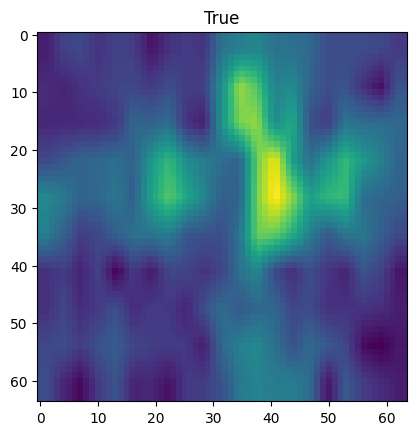

In [13]:
# Get the first spectrogram and label from the test set
spectrogram, metadata, label = boundingBoxDataset[400]
label = label.cpu().detach().numpy()

# Plot the spectrogram and label
fig, ax = plt.subplots(1, 1)
ax.imshow(spectrogram[0].reshape(64, 64))
ax.set_title(label[0] == 1)

# Get the predicted label
# Reshape the spectrogram to 1 dimension
spectrogram = spectrogram.reshape(1, -1).to(device)
metadata = metadata.reshape(1, -1).to(device)

inputs = torch.cat((spectrogram, metadata), dim=1)
predictedClass, predictedOffset = model(inputs)
predictedClass = predictedClass.detach().cpu().numpy()
predictedOffset = predictedOffset.detach().cpu().numpy()

predictedClass, predictedOffset

In [14]:
DATA_PATH = "data"
# Save the model
torch.save(model.state_dict(), os.path.join(DATA_PATH, "model.pt"))